# Percolation study on $10\times 10$ nm MAC at $T = 300$ K.

The purpose of this notebook is to test abd illustrate my code for finding spanning clusters of MOs in a snapshot of a MAC fragment during a $NVT$ MD simulation ran at $T = 300K$ .
Here, we are using the 800000th frame corresponding to $t = 40$ ps.

## Step 1: Loading the QCFFPI data

First, we read the data from the QCFFPI output files containing the MO matrix $M_{ij} = \langle\varphi_i | \psi_j\rangle$ and the MO energies $\varepsilon_j = \langle\psi_j|H|\psi_j\rangle$.

In [1]:
from os import path
from qcnico.coords_io import read_xsf
import numpy as np

datadir = path.expanduser('~/Desktop/simulation_outputs/percolation/40x40')
energy_dir = 'eARPACK'
mo_dir = 'MOs_ARPACK'
pos_dir = 'structures'


sample_index = 2
mo_file = f'MOs_ARPACK_bigMAC-{sample_index}.npy'
energy_file = f'eARPACK_bigMAC-{sample_index}.npy'

mo_path = path.join(datadir,mo_dir,mo_file)
energy_path = path.join(datadir,energy_dir,energy_file)
pos_path = path.join(datadir,pos_dir,f'bigMAC-{sample_index}_relaxed.xsf')

energies = np.load(energy_path)
M =  np.load(mo_path)
pos, _ = read_xsf(pos_path) 

In [2]:
# from os import path
# from time import perf_counter
# from qcnico.qcffpi_io import read_energies, read_MO_file

# datadir = path.expanduser('~/Desktop/simulation_outputs/qcffpi_data/MO_dynamics/300K_initplanar_norotate/')
# energy_dir = 'orbital_energies'
# mo_dir = 'MO_coefs'

# frame_nb = 80000
# mo_file = f'MOs_frame-{frame_nb}.dat'
# energy_file = f'orb_energy_frame-{frame_nb}.dat'

# mo_path = path.join(datadir,mo_dir,mo_file)
# energy_path = path.join(datadir,energy_dir,energy_file)

# energies = read_energies(energy_path)
# pos, M = read_MO_file(mo_path)

## Step 2: MO characteristics of our MAC fragment

Now that we have all of the quantum mechanical data extracted from our QCFFPI data files, let's check out the properties of this MAC fragment:

* how strongly strongly coupled are its MOs to the left and right electrodes?

* what do the most highly coupled MOs look like?

* what are the localisation characteristics of the fragment's MOs (e.g. do they exhibit torn localisation?)?

This will help guide our intuition and will allow us to set adequate criteria for when cluster of MOs can considered to span the whole fragment.

### Step 2a: MO-lead couplings.

First, we plot the relation between the energies and the coupling to the leads of each MO, where for MO $\psi_j\rangle$, the coupling to lead $\alpha$ is given by $\langle\psi_j|\Gamma_{\alpha}|\psi_j\rangle$ (for $\alpha\in\{L,R\}$).

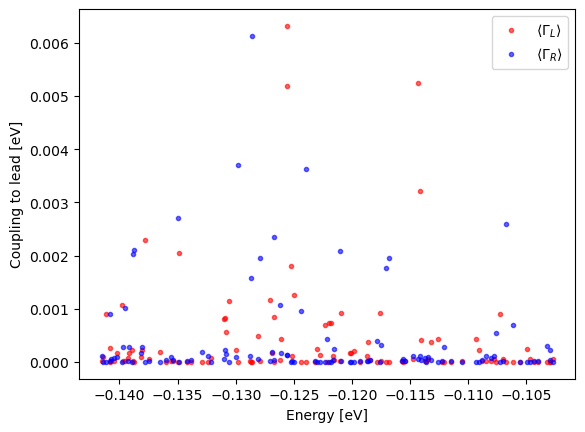

In [3]:
import qcnico.qchemMAC as qcm
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['image.aspect'] = 'auto'

# N = M.shape[0]
# #eF = 0.5 * ( energies[N//2] + energies[(N//2)-1] )
# eF = 0

# print(f'Fermi energy of fragment = {eF} eV')
# print(f'Bandwidth of fragment = {energies[-1] - energies[0]} eV')

# energies -= eF #center energies around eF occupied MOs have E<0 and unoccupied MOs have E>0

# ga = 0.1 #edge atome-lead coupling in eV
# print("Computing AO gammas...")
# agaL, agaR = qcm.AO_gammas(pos,ga)
# print("Computing MO gammas...")
# gamL, gamR = qcm.MO_gammas(M,agaL, agaR, return_diag=True)

gamL = np.load('gamL_40x40-2.npy')
gamR = np.load('gamR_40x40-2.npy')

plt.plot(energies, gamL, 'r.', label='$\langle\Gamma_L\\rangle$', alpha=0.6)
plt.plot(energies, gamR, 'b.', label='$\langle\Gamma_R\\rangle$', alpha=0.6)
plt.xlabel('Energy [eV]')
plt.ylabel('Coupling to lead [eV]')
plt.legend()
plt.show()



This is pretty noisy, but the most strongly coupled MOs are close to the Fermi energy (as expected). 

Now let's check the distribution of these MO-lead couplings.

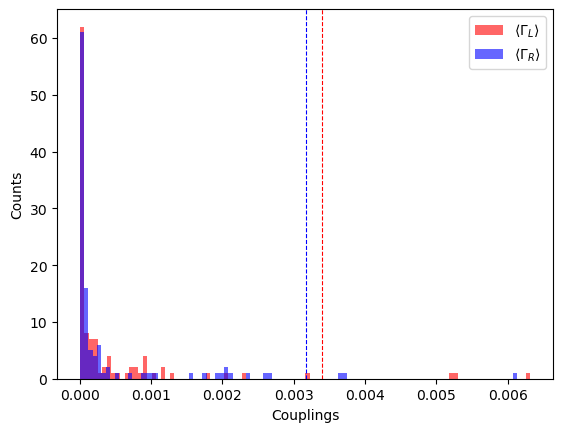

In [4]:
import numpy as np
import qcnico.plt_utils as plt_utils

tolscal = 3.0

fig, ax = plt.subplots()

plt_utils.histogram(gamL,nbins=100,xlabel='Couplings',show=False, normalised=False, plt_objs=(fig,ax),
    plt_kwargs={'alpha': 0.6, 'color': 'r', 'label': '$\langle\Gamma_L\\rangle$'})
plt_utils.histogram(gamR,nbins=100,show=False, normalised=False, plt_objs=(fig,ax),
    plt_kwargs={'alpha': 0.6, 'color': 'b', 'label': '$\langle\Gamma_R\\rangle$'})
plt.legend()
plt.axvline(x=np.mean(gamL) + tolscal*np.std(gamL), ymin=0, ymax=1, color='r', ls='--',lw=0.8)
plt.axvline(x=np.mean(gamR) + tolscal*np.std(gamR), ymin=0, ymax=1, color='b', ls='--',lw=0.8)
plt.show()


### Step 2b: Examining the morphology of the most strongly coupled MOs

OK, so it seems that very few MOs have couplings stronger than $\gamma_m = 0.01$ eV. We therefore set $\gamma_m$ to be the threshold for what we consider to be 'strong coupling. Let's examine what these strongly coupled MOs look like, and if any of them exhibit high values of both $\langle\Gamma_L\rangle$ and $\langle\Gamma_R\rangle$.

There are 3 MOs strongly coupled to the left electrode. 
There are 3 MOs strongly coupled to the right electrode. 


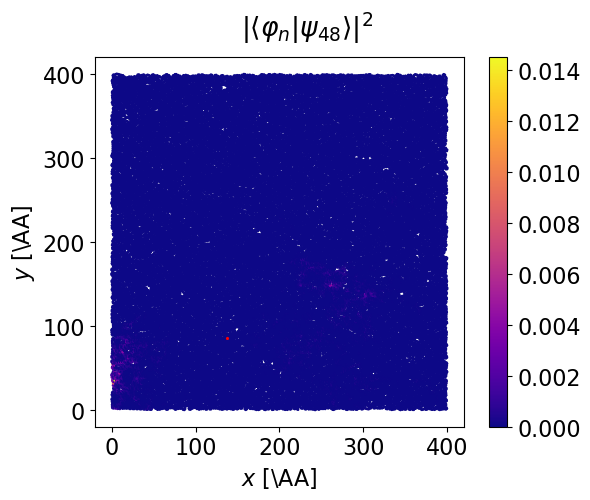

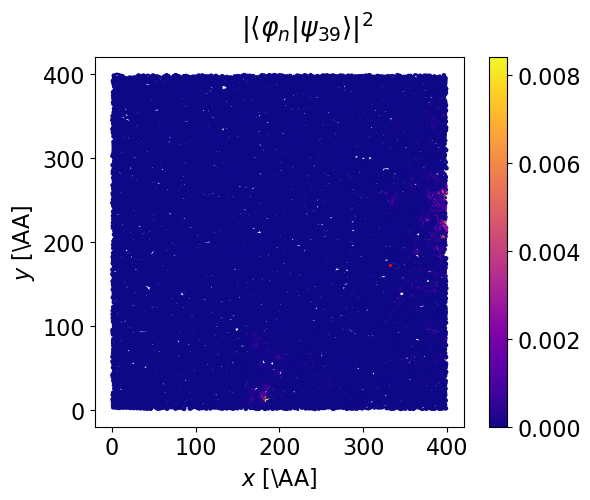

In [5]:
from qcnico.qcplots import plot_MO

gamL_tol = np.mean(gamL) + tolscal*np.std(gamL)
gamR_tol = np.mean(gamR) + tolscal*np.std(gamR)

biggaL_inds = (gamL > gamL_tol).nonzero()[0]
biggaR_inds = (gamR > gamR_tol).nonzero()[0]

print(f'There are {biggaL_inds.shape[0]} MOs strongly coupled to the left electrode. ')
print(f'There are {biggaR_inds.shape[0]} MOs strongly coupled to the right electrode. ')

jL = gamL.argmax() #index of MO max coupled to the left lead
jR = gamR.argmax() #index of MO max coupled to the right lead

plot_MO(pos, M, jL, show_COM=True,usetex=False, dotsize=1)

plot_MO(pos,M,jR,show_COM=True,usetex=False, dotsize=1)



### Step 2c: MO localisation characteristics

We now plot the distribution in $(1/\sqrt{\text{IPR}}, R_g, \varepsilon)$ space. We want to see of a similar pattern as observed for the $2\times4$ nm nanofragments emerges.

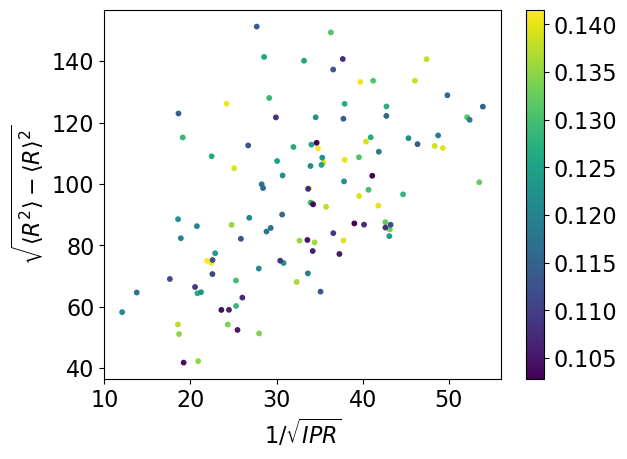

In [6]:
from qcnico.qcplots import plot_loc_discrep

iprs = qcm.inverse_participation_ratios(M)
rg = qcm.all_rgyrs(pos,M)

plot_loc_discrep(iprs, rg, np.abs(energies), usetex=False)

The MOs supported by this snapshot seem to exhibit slightly different localisation characterisitics than those in the ensemble of nanofragments:

* There appears to be a relatively localisation discrepancy; MOs with high $R_g$ (radius of gyration) will also have a high $1/\sqrt{\text{IPR}}$ (number of contributing sites), and vice-versa.

* High energy MOs tend to be highly localised; and low energy MO's are highly delocalised. MOs near $E_F$ are somewhere in the middle.

* There still appears to be a small subset of MOs with high $R_g$ but relatively low $1/\sqrt{IPR}$ these MOs tend to have energies close $E_F$.

### Step 3: Examine distance distribution between MOs

Before obtaining the percolation network, let's check out the distribution of Miller-Abrahams distances of our network. We compare this to the distribution of 'energy' distances (obtained by neglecting the )

6278
163


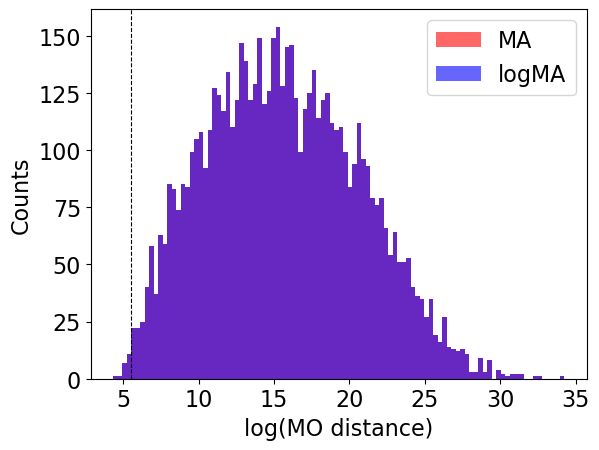

In [7]:
from percolate import dArray_MA, dArray_energy, dArray_logMA

coms = qcm.MO_com(pos, M)

distMA = dArray_MA(energies,coms,300, a0=30,eF=0)
distE = dArray_energy(energies,300,eF=0)
log_distMA = dArray_logMA(energies,coms,300, a0=30,eF=0)
print((distMA > 1e3).sum())
print((distMA <= 1e3).sum())

fig, ax = plt.subplots()

plt_utils.histogram(np.log(distMA),nbins=100,xlabel='log(MO distance)',show=False, normalised=False, plt_objs=(fig,ax),
    plt_kwargs={'alpha': 0.6, 'color': 'r', 'label': 'MA'})
plt_utils.histogram(log_distMA,nbins=100,xlabel='log(MO distance)',show=False, normalised=False, plt_objs=(fig,ax),
    plt_kwargs={'alpha': 0.6, 'color': 'b', 'label': 'logMA'})
# plt_utils.histogram(np.log(distE),nbins=100,show=False, normalised=False, plt_objs=(fig,ax),
#     plt_kwargs={'alpha': 0.6, 'color': 'b', 'label': 'Energy'})
plt.legend()
plt.axvline(x=np.mean(log_distMA) - 2.0*np.std(log_distMA), ymin=0, ymax=1, color='k', ls='--',lw=0.8)
#plt.axvline(x=np.mean(gamR) + 4*np.std(gamR), ymin=0, ymax=1, color='b', ls='--',lw=0.8)
plt.show()


In [8]:
print(np.min(distMA))
print(np.max(distMA))

76.33927841651257
739154862377236.1


### Step 4: Obtaining the percolating network

Finally, we now try to obtaining the cluster of MOs which could constitute a viable network for hopping conduction. 

We measure the 'resistance' between two MOs $|\psi_i\rangle$ and $|\psi_j\rangle$ (with energies $\varepsilon_i$ and $\varepsilon_j$, respectively) as follows:

$$
R_{ij} = \text{exp}\left\{\frac{|\varepsilon_i-\mu|+|\varepsilon_j-\mu| + |\varepsilon_i-\varepsilon_j|}{2k_{B}T} + \frac{2\,|\bm{r}_i - \bm{r}_j |}{a}\right\}\,,
$$

where $a$ is the "lengthscale" associated with the states between which the electron is hopping.
This is the expression from the Miller-Abrahams random resistor network model.

In [9]:
from percolate import percolate

conduction_clusters, dcrit, A = percolate(energies, pos, M, gamL_tol=gamL_tol,gamR_tol=gamR_tol, return_adjmat=True, distance='logMA',MOgams=(gamL, gamR))#, distance='energy')

d =  5.229697642506451
Nb. of connected pairs =  0
(array([], dtype=int64), array([], dtype=int64))
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


d =  5.59778223963084
Nb. of connected pairs =  1
(array([79]), array([6]))
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


d =  5.772224248091183
Nb. of connected pairs =  2
(array([79, 82]), array([6, 2]))
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


d =  7.67177461213004
Nb. of connected pairs =  3
(array([76, 79, 82]), array([41,  6,  2]))
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


d =  7.731760785610256
Nb. of connected pairs =  4
(array([76, 79, 80, 82]), array([41,  6, 21,  2]))
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]


Now that we've gotten a spanning cluster, let's check out what it looks like. We represent each MO in the cluster using its average position $\langle\psi|\bm{r}|\psi\rangle$.

MOs involved in the conduction cluster:  {0, 2, 5, 7, 9, 11, 13, 20, 22, 23, 26, 32, 33, 34, 35, 37, 38, 39, 40, 41, 47, 48, 49, 52, 59, 63, 69, 70, 71, 72, 76, 77, 78, 81, 82, 83, 85, 91, 94, 96, 97, 100, 103, 104, 105, 111}


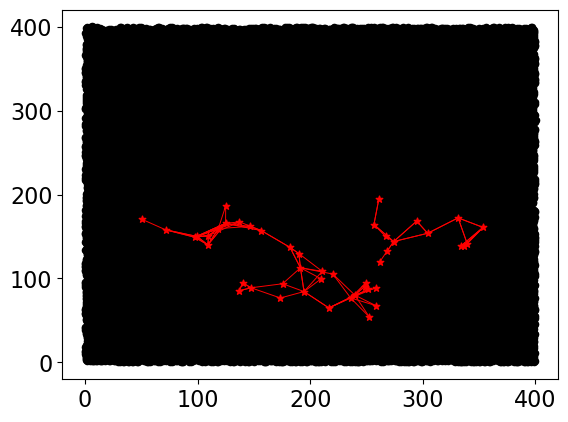

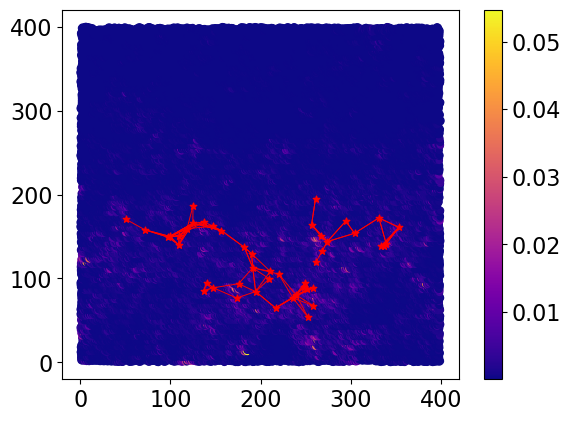

In [10]:
from percolate import plot_cluster

c = conduction_clusters[0]
print('MOs involved in the conduction cluster: ', c)

plot_cluster(c, pos, M, A, usetex=False, show_densities=False)
plot_cluster(c, pos, M, A, usetex=False, show_densities=True)

So it seems like one MO is connected to all of the others... which MO is this? Furthermore, of the MOs in the cluster above, which ones do we classify as 'strongly coupled' to the leads (using our above classification). Finally, what is the backbone of our conduction cluster? We answer all of these questions below.

In [11]:
print(conduction_clusters)
print(A)

[{0, 2, 5, 7, 9, 11, 13, 20, 22, 23, 26, 32, 33, 34, 35, 37, 38, 39, 40, 41, 47, 48, 49, 52, 59, 63, 69, 70, 71, 72, 76, 77, 78, 81, 82, 83, 85, 91, 94, 96, 97, 100, 103, 104, 105, 111}]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
